## Historical Data Platform QA/QC Event Evaluation Procedure
**Event**: Santa Ana Wind Event<br>
Start date: 2/16/1988<br> 
End date: 2/19/1988<br>
Location: Los Angeles, Orange counties<br>
Variables: wind speed, wind direction, air temperature, humidity<br>

In [1]:
# import libraries
import pandas as pd
import numpy as np
import xarray as xr
import geopandas as gpd
from geopandas import GeoDataFrame
from shapely.geometry import Point
%load_ext autoreload
%autoreload 2

### Clone GHCNh library

```bash
git clone https://github.com/Eagle-Rock-Analytics/GHCNh.git
cd GHCNh
branch="origin/ghcnh_class_dev"
git branch --track ${branch##origin/} $branch

#### Import GHCNh class

```python
from GHCNh.GHCNh_lib import GHCNh
ghcnh = GHCNh()```

#### Plot GHCNh stations

```python
wecc_terr = "s3://wecc-historical-wx/0_maps/WECC_Informational_MarineCoastal_Boundary_land.shp"
wecc_mar = "s3://wecc-historical-wx/0_maps/WECC_Informational_MarineCoastal_Boundary_marine.shp"
t = gpd.read_file(wecc_terr).iloc[0].geometry  ## Read in terrestrial WECC shapefile.
m = gpd.read_file(wecc_mar).iloc[0].geometry   ## Read in marine WECC shapefile.

fig,ax = plt.subplots(subplot_kw={'projection':ccrs.PlateCarree()})

ax.coastlines()
ax.add_feature(cf.BORDERS)
ax.add_geometries(m, crs=ccrs.PlateCarree(), color="C0", alpha=0.25)
ax.add_geometries(t, crs=ccrs.PlateCarree(), color="C1", alpha=0.25)
# ax.add_feature(cf.STATES, lw=0.5)
ax.set_extent([-130, -100, 28, 52])
ax.plot(ghcnh.stations_df['longitude'], ghcnh.stations_df['latitude'], 
        marker='.', lw=0, c="k", ms=2, label="WECC")
tmp = ghcnh.stations_df[~ghcnh.stations_df['is_in_wecc']]
ax.plot(tmp['longitude'], tmp['latitude'], 
        marker='.', lw=0, c="red", ms=2, label="Not WECC")
ax.legend()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.yaxis.set_major_locator(MaxNLocator(integer=True))

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=["bottom", "left"],
                  ls=":", lw=0.5)
ax.set_title("GHCNh stations");
```

#### Select WECC 

``` python
ghcnh.select_wecc()
id = ghcnh.stations_df['id'].iloc[0]
print(id)
ghcnh.read_data_from_url(id=id)
ghcnh.station_data
```

#### Plot some variables from the read station

``` python
fig,ax = plt.subplots()

ghcnh.station_data.plot(ax=ax, x="time", y="temperature")
ghcnh.station_data.plot(ax=ax, x="time", y="dew_point_temperature")
ax.set_title(id);
```

In [2]:
from GHCNh.GHCNh_lib import GHCNh
ghcnh = GHCNh()

In [5]:
ghcnh.select_wecc()
id = ghcnh.stations_df['id'].iloc[0]

### QAQC evaluation

In [3]:
# read in stations
train_stns = pd.read_csv('../qaqc_training_station_list_events.csv')

In [4]:
# identify stations with coverage of event
event_flags = ['all', 'santa_ana_wind']
event_stns = train_stns[train_stns['event_type'].isin(event_flags)]

# exclude "manual check on end date" for the time being -- SNOTEL stations all have 2100 as their end date regardless of when the data actually ends
mask = event_stns['notes'] == 'manual check on end date'
event_stns = event_stns[~mask]
event_stns

,network,era-id,elevation,latitude,longitude,start_date,end_date,event_type,notes
3,ASOSAWOS,ASOSAWOS_72281023199,-14.0208,32.83200,-115.66400,1984-04-13 00:00:00+00:00,2022-12-31 00:00:00+00:00,all,NaN
7,ASOSAWOS,ASOSAWOS_72288023152,222.8088,34.20000,-118.36500,1943-06-01 00:00:00+00:00,2022-12-31 00:00:00+00:00,all,NaN
9,ASOSAWOS,ASOSAWOS_72288623130,239.2680,34.21200,-118.49100,1942-12-11 00:00:00+00:00,2022-12-31 00:00:00+00:00,all,NaN
11,ASOSAWOS,ASOSAWOS_72290023188,4.5720,32.73400,-117.18300,1942-01-01 00:00:00+00:00,2022-12-31 00:00:00+00:00,all,NaN
14,ASOSAWOS,ASOSAWOS_72290693112,4.2672,32.69200,-117.21000,1945-04-01 00:00:00+00:00,2022-12-31 00:00:00+00:00,all,NaN
...,...,...,...,...,...,...,...,...,...
248,CIMIS,CIMIS_75,410.0000,33.68845,-117.72118,1987-10-07 00:00:00+00:00,2024-01-22 13:36:19.951554+00:00,all,NaN
249,CIMIS,CIMIS_76,160.0000,34.92400,-120.51200,1987-12-18 00:00:00+00:00,1993-07-01 00:00:00+00:00,santa_ana_wind,NaN
252,CIMIS,CIMIS_9,406.0000,35.23800,-118.89400,1982-09-29 00:00:00+00:00,1989-04-10 00:00:00+00:00,santa_ana_wind,NaN
708,OtherISD,OtherISD_72286023119,468.2000,33.90000,-117.25000,1933-01-01 00:00:00+00:00,2023-03-14 00:00:00+00:00,all,NaN


In [4]:
# identify stations that are in the geographic region we are looking for
# santa ana wind event, focusing on LA and Orange counties

# this may not be the best procedure for us -- hector thoughts?
ca_county = gpd.read_file('../../figures/ca_county_boundaries.shp') # may need to change the path to the shapefile
county_names = ['Los Angeles', 'Orange']
target_counties = ca_county[ca_county['NAME'].isin(county_names)]

# process event list to subset
geometry = [Point(xy) for xy in zip (event_stns.longitude, event_stns.latitude)]
event_stns = GeoDataFrame(event_stns, crs="EPSG:3857", geometry=geometry) # adding geometry column
event_stns_local = gpd.overlay(event_stns, target_counties, how="intersection") # subsetting for stations within county boundaries

# subset further based on number, if needed
if len(event_stns_local) > 20:
    event_stns_local = event_stns_local.sample(20)

event_stns_local

,network,era-id,elevation,latitude,longitude,start_date,end_date,event_type,notes,STATEFP,...,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,Shape_Leng,Shape_Area,geometry
0,ASOSAWOS,ASOSAWOS_72288623130,239.2680,34.21200,-118.49100,1942-12-11 00:00:00+00:00,2022-12-31 00:00:00+00:00,all,NaN,06,...,31080,31084,A,1.051599e+10,1.785003e+09,+34.1963983,-118.2618616,7.285334,1.203189,POINT (-118.491 34.212)
1,ASOSAWOS,ASOSAWOS_72297023129,10.3632,33.81200,-118.14700,1943-01-01 00:00:00+00:00,2022-12-31 00:00:00+00:00,all,NaN,06,...,31080,31084,A,1.051599e+10,1.785003e+09,+34.1963983,-118.2618616,7.285334,1.203189,POINT (-118.147 33.812)
2,ASOSAWOS,ASOSAWOS_72288023152,222.8088,34.20000,-118.36500,1943-06-01 00:00:00+00:00,2022-12-31 00:00:00+00:00,all,NaN,06,...,31080,31084,A,1.051599e+10,1.785003e+09,+34.1963983,-118.2618616,7.285334,1.203189,POINT (-118.365 34.200)
3,ASOSAWOS,ASOSAWOS_72292593117,55.4736,33.02300,-118.58800,1943-06-10 00:00:00+00:00,2022-12-31 00:00:00+00:00,all,NaN,06,...,31080,31084,A,1.051599e+10,1.785003e+09,+34.1963983,-118.2618616,7.285334,1.203189,POINT (-118.588 33.023)
4,ASOSAWOS,ASOSAWOS_72292023191,477.0120,33.40400,-118.41500,1943-06-12 00:00:00+00:00,2022-12-31 00:00:00+00:00,all,NaN,06,...,31080,31084,A,1.051599e+10,1.785003e+09,+34.1963983,-118.2618616,7.285334,1.203189,POINT (-118.415 33.404)
5,ASOSAWOS,ASOSAWOS_72382023182,764.7432,34.62900,-118.08300,1973-01-01 00:00:00+00:00,2022-12-31 00:00:00+00:00,all,NaN,06,...,31080,31084,A,1.051599e+10,1.785003e+09,+34.1963983,-118.2618616,7.285334,1.203189,POINT (-118.083 34.629)
6,ASOSAWOS,ASOSAWOS_72383023187,1374.6480,34.74400,-118.72500,1973-01-01 00:00:00+00:00,2022-12-31 00:00:00+00:00,all,NaN,06,...,31080,31084,A,1.051599e+10,1.785003e+09,+34.1963983,-118.2618616,7.285334,1.203189,POINT (-118.725 34.744)
7,ASOSAWOS,ASOSAWOS_72381603159,712.6224,34.74100,-118.21300,1974-06-01 00:00:00+00:00,2022-12-31 00:00:00+00:00,all,NaN,06,...,31080,31084,A,1.051599e+10,1.785003e+09,+34.1963983,-118.2618616,7.285334,1.203189,POINT (-118.213 34.741)
8,CIMIS,CIMIS_75,410.0000,33.68845,-117.72118,1987-10-07 00:00:00+00:00,2024-01-22 13:36:19.951554+00:00,all,NaN,06,...,31080,11244,A,2.053499e+09,4.062561e+08,+33.6756872,-117.7772068,2.188130,0.239146,POINT (-117.721 33.688)
9,CIMIS,CIMIS_75,410.0000,33.68845,-117.72118,1987-10-07 00:00:00+00:00,2024-01-22 13:36:19.951554+00:00,all,NaN,06,...,31080,11244,A,2.053499e+09,4.062561e+08,+33.6756872,-117.7772068,2.188130,0.239146,POINT (-117.721 33.688)


### Step 2: Holistic / qualitative station evaluation
* downloading these stations manually into train_files, but should grab from AWS unless a better way to read nc files from AWS...

In [ ]:
# phase 2 look at full timeseries for flags -- grabbing clean version, not qaqc version to build out
# alternatively.... some of these files may be very large and we should avoid reading in all because of memory concerns

# for stn in event_stns:
#     want to pull out all flags noted, frequency of flags of time record 

In [8]:
# read a single station in
stn = xr.open_dataset('~/Desktop/eaglerock/historical-data-platform/Train_Files/CIMIS_75.nc')
stn

<xarray.Dataset>
Dimensions:          (station: 1, time: 305943)
Coordinates:
  * time             (time) datetime64[ns] 1987-10-07T09:00:00 ... 2022-08-31...
  * station          (station) object 'CIMIS_75'
    lat              (station, time) float64 ...
    lon              (station, time) float64 ...
Data variables: (12/17)
    tas              (station, time) float64 ...
    pr               (station, time) float64 ...
    hurs             (station, time) float64 ...
    rsds             (station, time) float64 ...
    sfcWind          (station, time) float64 ...
    sfcWind_dir      (station, time) float64 ...
    ...               ...
    tdps_derived_qc  (station, time) object ...
    sfcWind_qc       (station, time) object ...
    sfcWind_dir_qc   (station, time) object ...
    elevation        (station, time) float64 ...
    tdps_derived     (station, time) float64 ...
    pvp_derived      (station, time) float64 ...
Attributes: (12/16)
    title:                 CIMIS cleaned
    institution:           Eagle Rock Analytics / Cal Adapt
    source:                
    history:               CIMIS_clean.py script run on 02-13-2023, 22:25:54 UTC
    comment:               Intermediate data product: may not have been subje...
    license:               
    ...                    ...
    wind_vane_height_m:    2.0
    anemometer_height_m:   2.0
    thermometer_height_m:  1.5
    humidity_height_m:     1.5
    rain_gauge_height_m:   1.0
    raw_files_merged:      47

In [38]:
def id_all_flags(ds):
    '''Prints all unique values of all eraqaqc flags'''
    ds_vars = list(stn.keys())
    qc_vars = [i for i in ds_vars if '_eraqc' in i]
    if len(qc_vars) == 0:
        print('Station has no eraqc variables -- please double check that this station has completed QA/QC!')
    else:
        for var in qc_vars:
            print(var, np.unique(ds[var].data))

In [39]:
id_all_flags(stn)

pr_qc ['M' 'P' 'Q' 'R' 'Y' 'nan']
rsds_qc ['M' 'P' 'R' 'S' 'Y' 'nan']
pvp_derived_qc ['M' 'P' 'Q' 'R' 'S' 'Y' 'nan']
tas_qc ['M' 'P' 'R' 'S' 'Y' 'nan']
hurs_qc ['M' 'Q' 'R' 'S' 'Y' 'nan']
tdps_derived_qc ['M' 'Q' 'R' 'S' 'Y' 'nan']
sfcWind_qc ['I' 'M' 'P' 'R' 'S' 'Y' 'nan']
sfcWind_dir_qc ['I' 'M' 'P' 'Q' 'R' 'nan']


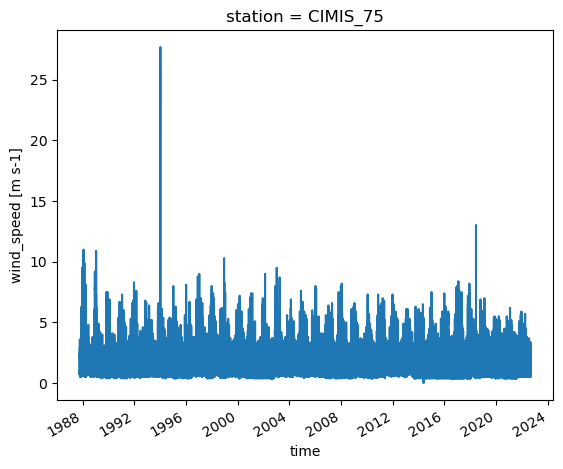

In [47]:
# look at full timeseries for holistic view
stn.sfcWind.plot()

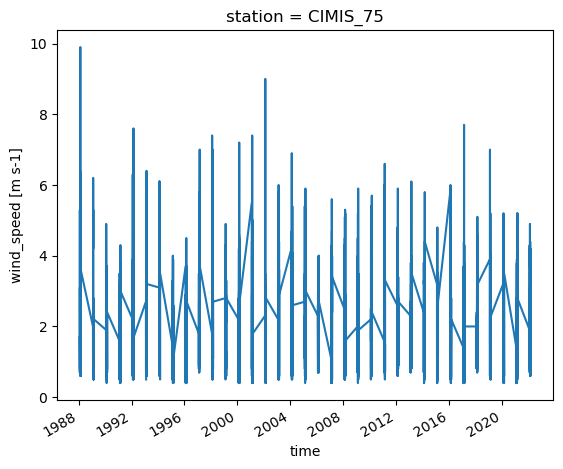

In [57]:
# look at timeseries of all months of that event (e.g., all februaries) to understand climatological signal?
month = [2]
stn_monthly_clim = stn.isel(time=stn.time.dt.month.isin(month))

stn_monthly_clim.sfcWind.plot()

# hmm not so useful, perhaps a climatology of the month to compare with the event

In [44]:
# look at timeseries during event for flags
# decision: do we add a few days prior/after event end date to evaluate "event anomaly"? i think this may be useful
# santa ana event was 2/16/1988 to 2/19/1988; including +/- 1 week
event_start_date = '1988-02-09'
event_end_date = '1988-02-26'

# subset for event period of time
event = stn.sel(time=slice(event_start_date, event_end_date))

<xarray.Dataset>
Dimensions:          (station: 1, time: 432)
Coordinates:
  * time             (time) datetime64[ns] 1988-02-09 ... 1988-02-26T23:00:00
  * station          (station) object 'CIMIS_75'
    lat              (station, time) float64 ...
    lon              (station, time) float64 ...
Data variables: (12/17)
    tas              (station, time) float64 ...
    pr               (station, time) float64 ...
    hurs             (station, time) float64 ...
    rsds             (station, time) float64 ...
    sfcWind          (station, time) float64 ...
    sfcWind_dir      (station, time) float64 ...
    ...               ...
    tdps_derived_qc  (station, time) object 'nan' 'nan' 'nan' ... 'nan' 'nan'
    sfcWind_qc       (station, time) object 'nan' 'nan' 'nan' ... 'nan' 'nan'
    sfcWind_dir_qc   (station, time) object 'nan' 'nan' 'nan' ... 'nan' 'nan'
    elevation        (station, time) float64 ...
    tdps_derived     (station, time) float64 ...
    pvp_derived      (station, time) float64 ...
Attributes: (12/16)
    title:                 CIMIS cleaned
    institution:           Eagle Rock Analytics / Cal Adapt
    source:                
    history:               CIMIS_clean.py script run on 02-13-2023, 22:25:54 UTC
    comment:               Intermediate data product: may not have been subje...
    license:               
    ...                    ...
    wind_vane_height_m:    2.0
    anemometer_height_m:   2.0
    thermometer_height_m:  1.5
    humidity_height_m:     1.5
    rain_gauge_height_m:   1.0
    raw_files_merged:      47

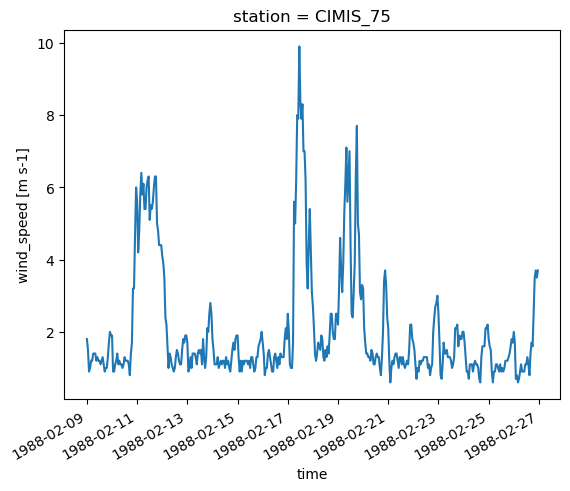

In [45]:
# just grabbing a single var for the event itself
event.sfcWind.plot()

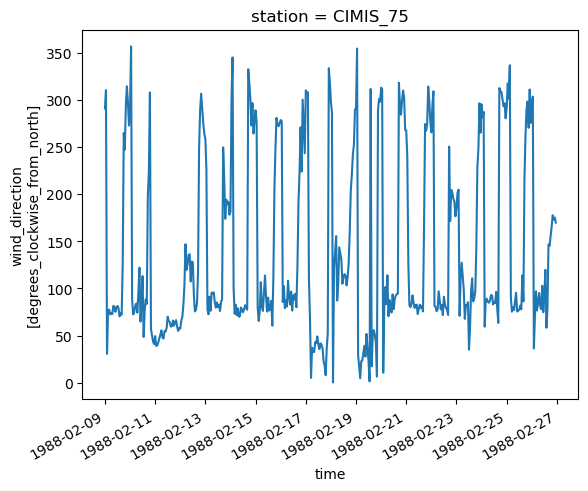

In [52]:
event.sfcWind_dir.plot()

In [ ]:
# look at all stations (5-20 view) for the event to qualitatively get a sense of how stations did during the event with regards to qaqc flags

### Step 3: Validate against other QA/QC'd data
* GHCNh data -- need to figure out how to read this funky file format first

In [ ]:
# read in ghcnh data
## hector working on this

In [ ]:
#

In [ ]:
# initial test for identifying the event: large jumps on windspeed